In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import cv2 as cv
# use seaborn plotting defaults
import seaborn as sns; sns.set()
import numpy.random as nr

In [6]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/Users/dami.osoba/opt/anaconda3/bin/python
3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


In [9]:
dataset = pd.read_csv('statefarm_data/driver_imgs_list.csv')
dataset.head(5)


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [10]:
dataset['classname'].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64

In [11]:
dataset.shape

(22424, 3)

In [16]:
N= 1000
reduced_sample = dataset.groupby('classname', group_keys=False)\
.apply(lambda x: x.sample(int(np.rint(N*len(x)/len(dataset))))).sample(frac=1).reset_index(drop=True)


In [17]:
reduced_sample

,subject,classname,img
0,p052,c3,img_18860.jpg
1,p041,c3,img_55189.jpg
2,p022,c1,img_47641.jpg
3,p024,c4,img_52427.jpg
4,p056,c1,img_40616.jpg
...,...,...,...
995,p061,c6,img_56760.jpg
996,p064,c0,img_66609.jpg
997,p049,c9,img_86713.jpg
998,p052,c6,img_76039.jpg


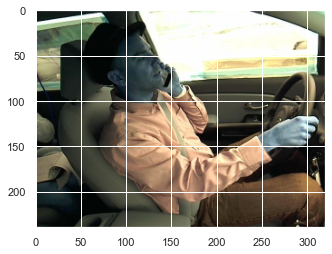

In [77]:
X_train = []
y_train = []
for index,row in reduced_sample.iterrows():
    img = cv.imread("statefarm_data/imgs/train/{}/{}".format(row['classname'],row['img']))
    img = cv.resize(img, (64*5, 48*5)) 
    X_train.append(img)
    y_train.append(row['classname'])
plt.imshow(X_train[3])
y_train = np.array(y_train)

In [90]:
np.flatnonzero(y_train == 'c0')

array([ 38,  49,  50,  62,  64,  85,  88, 102, 118, 129, 138, 146, 152,
       178, 182, 183, 196, 198, 200, 205, 214, 226, 228, 236, 245, 252,
       266, 271, 281, 284, 288, 292, 294, 295, 301, 304, 324, 325, 328,
       337, 339, 345, 359, 365, 370, 377, 384, 388, 397, 403, 442, 444,
       466, 474, 475, 479, 480, 491, 495, 530, 535, 542, 551, 554, 556,
       572, 577, 578, 601, 611, 616, 618, 640, 665, 695, 696, 700, 725,
       731, 750, 757, 759, 774, 776, 781, 785, 788, 795, 796, 818, 821,
       829, 839, 845, 850, 854, 884, 887, 898, 918, 932, 935, 936, 953,
       962, 969, 971, 974, 977, 996, 999])

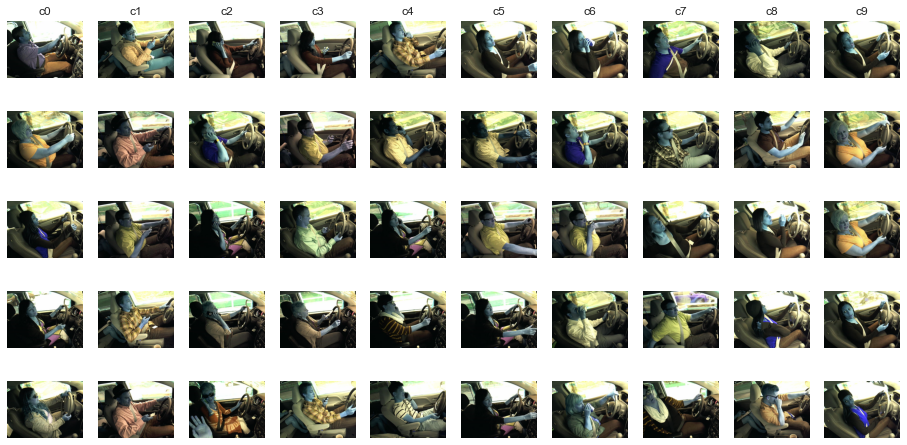

In [95]:
classes = np.unique(dat_class)
num_classes = len(classes)
samples_per_class = 5
plt.figure(figsize=(16, 8)) 
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx],)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()